<a href="https://colab.research.google.com/github/ojasrai17/DeepLearning/blob/main/DL_buildings_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Tutorial on  2D UNet CNN for Single Object Land Cover Segmentation from Remote Sensing Images using Tensorflow Deep Learning Library

This tutorial includes the implementation of the deep learning model-UNet CNN  for binary semantic segmentation from high resolution satellite remote sensing images. The following are the steps involved in this process.
1. Import necessary libraries and dataset
2. Prepare data for processing
3. Create the deep learning(DL) model
4. Compile and train the model
5. Model evalution
6. Model prediction  
7. Evaluation of performance of the model

# Part-1 Task: Building Object Segmentation from Remote Sensing Images

## Step 1. Importing library packages

The packages imported here are TensorFlow dependencies, NumPy, Glob and Matplotlib. NumPy is the fundamental package used for working with arrays. The dataset is taking as a list by using Glob. Matplotlib is used here to read and display the images.

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import cv2
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.metrics import MeanIoU, Accuracy

In [ ]:
## For local system GPU
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#     except RuntimeError as e:
#         print(e)

## Step 2. Dataset preparation
* The dataset used here is the Massachusetts Buildings dataset. It consists of 151 aerial images of the Boston area, with each of the images being 1500 × 1500 pixels for an area of 2.25 square kilometers.
*Hence, the entire dataset covers roughly 340 square kilometers. The data is split into a training set of 137 images, a test set of 10 images and a validation set of 4 images.
* The target maps were obtained by rasterizing building footprints obtained from the OpenStreetMap project. The dataset covers mostly urban, suburban areas and buildings of all sizes, including individual houses and garages, are included in the labels.
* The datasets make use of imagery released by the state of Massachusetts.
* All imagery is rescaled to a resolution of 1 pixel per square meter.
* The target maps for the dataset were generated using data from the OpenStreetMap project.
* Target maps for the test and validation portions of the dataset were hand-corrected to make the evaluations more accurate.

* Source of Massachusetts Building Dataset: https://www.kaggle.com/balraj98/massachusetts-buildings-dataset

In [ ]:
from google.colab import drive
drive.mount('https://drive.google.com/drive/folders/1FXKrxw19n0T6OOLKDaRYatiuUqbM33Gv?usp=drive_link')

ValueError: Mountpoint must be in a directory that exists

In [ ]:
# /content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData

In [ ]:
from keras import backend as K
def adjustData(img, mask):
  onehot=mask/255                 ###pixel normalization
  return(img, onehot)

def TrainGenerator(aug_dict, image_folder, mask_folder, batch_size, save_to_dir, seed = 1, image1_save_prefix = "image",  mask_save_prefix = "mask"):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)

  image_generator = image_datagen.flow_from_directory(
       directory = image_folder,
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = mask_folder,
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image_generator, mask_generator)
  for (img, mask) in train_generator:
        X=[]
        Y=[]
        for d in range(img.shape[0]):
            x, y = adjustData(img[d], mask[d])
            X.append(x)
            Y.append(y)
        X = np.reshape(np.array(X),(img.shape[0],512, 512,3))
        Y = np.reshape(np.array(Y),(img.shape[0],512, 512,1))
        yield X, Y

def ValGenerator(aug_dict, image_folder, mask_folder, batch_size, save_to_dir, seed = 1, image_save_prefix = "image", mask_save_prefix = "mask"):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)

  image_generator = image_datagen.flow_from_directory(
       directory = image_folder,
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = mask_folder,
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )

  valid_generator = zip(image_generator, mask_generator)
  for (img, mask) in valid_generator:
        X=[]
        Y=[]
        for d in range(img.shape[0]):
            x, y = adjustData(img[d], mask[d])
            X.append(x)
            Y.append(y)
        X = np.reshape(np.array(X),(img.shape[0],512, 512,3))
        Y = np.reshape(np.array(Y),(img.shape[0],512, 512,1))
        yield X, Y

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict()
Generator = TrainGenerator(aug_dict=data_gen_args,image_folder='/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Train/I/',
                           mask_folder='/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Train/G/',batch_size=4,save_to_dir=None)
Val = ValGenerator(aug_dict=data_gen_args,image_folder='/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Val/I/',
                   mask_folder='/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Val/G/',batch_size=4,save_to_dir=None)



## Step 3. Creating Model: U-Net Model

The U-Net has a contracting path and an expansive path. The contracting path consists of repeated application of two 3x3 convolutions followed by a ReLu activation function and a 2x2 maxpooling layer with stride 2 for down-sampling. After each down-sampling, the number of filters is doubled.

In the expansive path, the feature map is up-sampled by using 2x2 transpose convolution with a stride 2 which halves the number of feature channel, concatenated with the corresponding feature map in the contracting path and two 3x3 convolutions followed by ReLU activation function. At the final layer, 1x1 convolution is carried out with the number of filters is equal to the number of classes and followed by a sigmoid activation function.

The kernel initializer adopted here is 'he_normal'.

In [ ]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encode module
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.4) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Decoder module
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

## Step 4. Compiling and Training  model

### 4.1. Compiling model: Model parameter setting and selection of loss function

The optimizer used here is Adam with a learning rate of 0.0001 and the loss function is 'binary_crossentropy'

In [ ]:
# define loss function
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### 4.2: Training of model:
The model  will be trained for 10 epochs with a batch size 4. The best weight, with less validation loss is saving as h5 file. Early stopping is included such that if the validation loss is not decreasing for consecutive 3 epochs (patience=3), then the training will be stopped.

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5,patience=10,verbose=1,cooldown=1,min_delta=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=20,verbose=1,mode='min',restore_best_weights=True)
check_path = '/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/UNet_Building.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='min')

history = model.fit(Generator,validation_data =Val, validation_steps= 9,steps_per_epoch=308,shuffle=True,verbose=1,epochs=10,callbacks=[reduce_lr,early_stop,checkpoint])

Found 1233 images belonging to 1 classes.
Found 1233 images belonging to 1 classes.
Epoch 1/10
308/308 [==============================] - ETA: 0s - loss: 3.2643 - accuracy: 0.7653Found 36 images belonging to 1 classes.
Found 36 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 0.93955, saving model to /content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/UNet_Building.h5
308/308 [==============================] - 682s 2s/step - loss: 3.2643 - accuracy: 0.7653 - val_loss: 0.9395 - val_accuracy: 0.8337 - lr: 1.0000e-04
Epoch 2/10
308/308 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.8277
Epoch 2: val_loss improved from 0.93955 to 0.60214, saving model to /content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/UNet_Building.h5
308/308 [==============================] - 63s 190ms/step - loss: 0.9278 - accuracy: 0.8277 - val_loss: 0.6021 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 3/10
308/308 [==============================] - ETA: 0

## Step 5. Visualization of training loss and accuracy

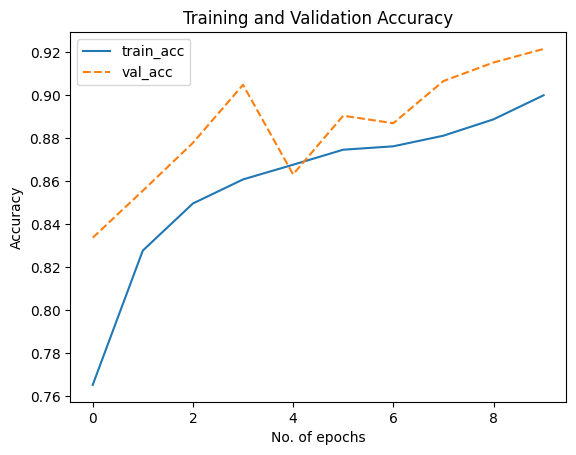

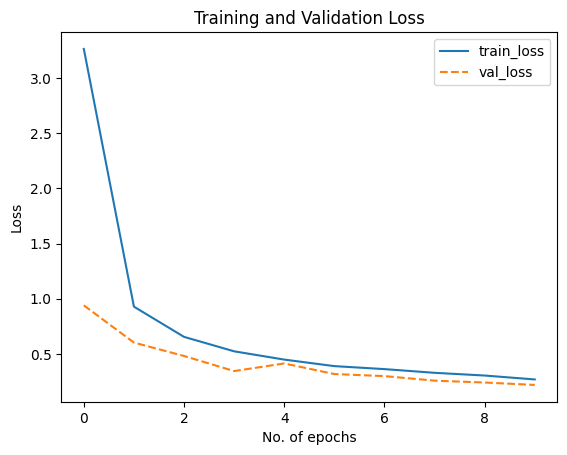

In [ ]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# model.load_weights('I:/building/building_unet_count.h5')
model.load_weights('/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/building_unet.h5')
# model.load_weights('/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/building_unet_count.h5')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 256, 256, 16)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

## Step 6. Model prediction

In [ ]:
import os
gtappend = []
predappend =[]
imgs = []
addA = "/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Test/I/x/"
addlabel = "/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/BuildingData/Test/G/y/"

for eg in os.listdir(addA):
    imageA = addA + str(eg)
    GT = addlabel + str(eg)
    x1 = (plt.imread(imageA))*255
    x2 = (plt.imread(GT))
    a = np.reshape(x1,(1,512,512,3))
    c = x2[:,:,0]
    y = model.predict(a)
    y = np.reshape(y,(512,512))
    result = np.where(y>0.5,1,0)
    predappend.append(result)
    gtappend.append(c)
    imgs.append(x1)

g = np.stack(gtappend, axis=0)
p = np.stack(predappend, axis=0)
imgs = np.array(imgs)

1/1 [==============================] - 0s 23ms/step


In [ ]:
img.shape

(90, 512, 512, 3)

Text(0.5, 1.0, 'Predicted image')

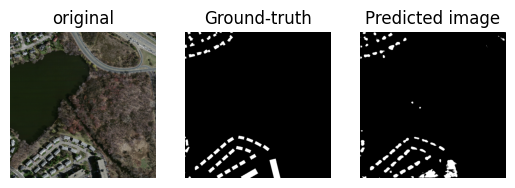

In [ ]:
fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
ax.imshow((imgs[2]/255))
plt.axis('off')
plt.title("original")

ax=fig.add_subplot(1,3,2)
ax.imshow(np.reshape(g[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
ax.imshow(np.reshape(p[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

Text(0.5, 1.0, 'Predicted image')

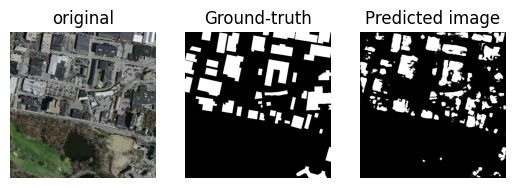

In [ ]:
fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
ax.imshow((imgs[19]/255))
plt.axis('off')
plt.title("original")

ax=fig.add_subplot(1,3,2)
ax.imshow(np.reshape(g[19],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
ax.imshow(np.reshape(p[19],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

## Step 7. Performance evaluation of the model

The performance of the model is evaluated by using the metrics Mean IoU, Accuracy, Precision, Recall, Kappa coefficient and Dice coefficient.

In [ ]:
from sklearn.metrics import *
gt=(g.ravel()).astype('int')
pd=(p.ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

### Dice Coefficient
def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc

dice_coeff = get_dice(g, p)
print("dc = ",np.mean(dice_coeff))

[0 1] [0 1]
F1 SCORE: 0.7746654226671458
Kappa: 0.5515130376036574
Accuracy: 0.8785417768690321
Jaccard Score: 0.65805570199944
Precision: 0.8199315026301996
Recall: 0.7464955460333598
dc =  0.6216721732443039


# Part-2 Task: Counding of Number of Building in the Predicted Image and Ground truth images

In [ ]:
import random
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage import measure
from skimage import filters

def Opening(image, filter_size):
    #Opening is just another name of erosion followed by dilation
    img=np.copy(image)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(filter_size,filter_size))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

def Closing(image,k):# closing is useful to detect the overall contour of a figure and opening is suitable to detect subpatterns.
    kernel = np.ones((k, k), np.uint8)
    img=np.copy(image)
    img_close = cv2.morphologyEx(img, op= cv2.MORPH_CLOSE,kernel=kernel)
    return img_close

def Denoise(image,k):
    img=np.copy(image)
    struct=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))
    img=cv2.morphologyEx(img,cv2.MORPH_OPEN,struct)
    return img

def Binary(image, threshold, max_value = 1):
    img=np.copy(image)
    (t,masklayer)=cv2.threshold(img,threshold,max_value,cv2.THRESH_BINARY)
    return masklayer

def Gaussian_filter(image, sigma =1):
    img=np.copy(image)
    blur = filters.gaussian(img, sigma=sigma)
    return blur

def Find_threshold_otsu(image):
    t = filters.threshold_otsu(image)
    return t

def ExtractObjects(image):
    img=np.copy(image)
    blob_labels=measure.label(img,background=0)
    number_of_objects=np.unique(blob_labels)
    return blob_labels,number_of_objects

def post_processing(img):

    blur = Gaussian_filter(img, sigma=1)
    t = Find_threshold_otsu(blur)
    binary_img = Binary(blur,t)
    opened_img  = Opening(binary_img, filter_size = 3)
    blob_labels,number_of_objects = ExtractObjects(opened_img)

    return opened_img, number_of_objects, blob_labels

In [ ]:
imgs.shape

(90, 512, 512, 3)

Number of Buildings in prediction: 170
Number of Buildings in Groundtruth: 95


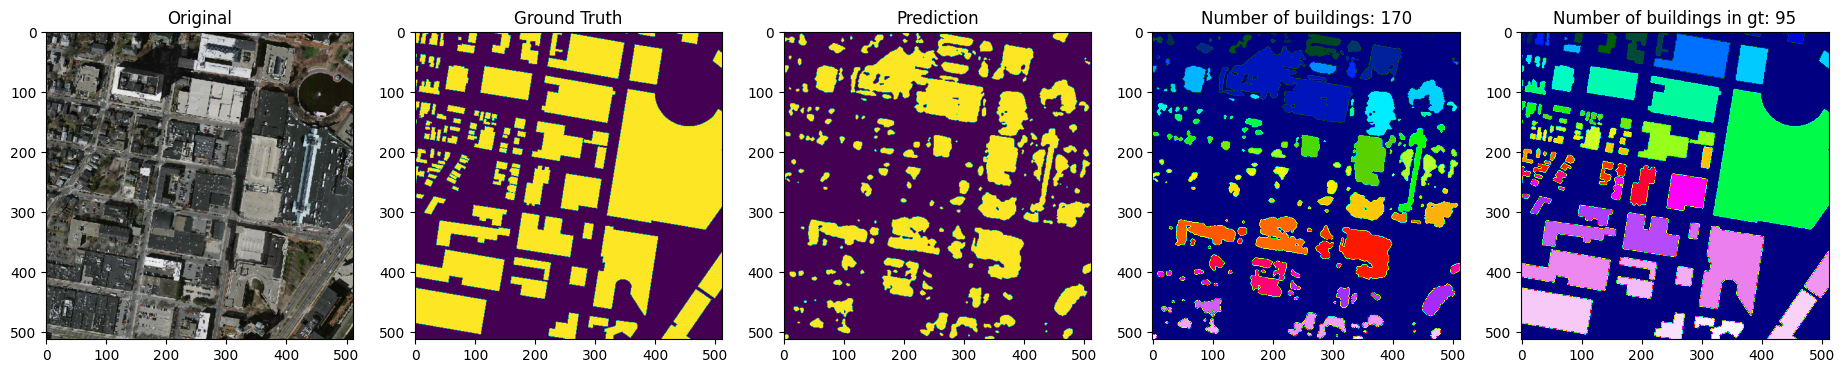

In [ ]:
number = 0 #56 ,34
pred = p[number,:,:]

opened_img, number_of_objects, blob_labels = post_processing(pred)
print("Number of Buildings in prediction: {}".format(number_of_objects[-1]))

gt = g[number,:,:]
opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)
print("Number of Buildings in Groundtruth: {}".format(number_of_objects1[-1]))

f, axs = plt.subplots(1,5, figsize=(23,23))
img = imgs[number,:,:,:]/255
img = np.reshape(img,(img.shape[0],img.shape[1],3))
# img = img.astype('uint8')
axs[0].imshow(img)
axs[0].set_title("Original")

gt = g[number,:,:]
gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
axs[1].imshow(gt)
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of buildings: {}".format(number_of_objects[-1]))

axs[4].imshow(blob_labels1, cmap='gist_ncar')
axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

f.show()

Number of Buildings in prediction: 314
Number of Buildings in Groundtruth: 389


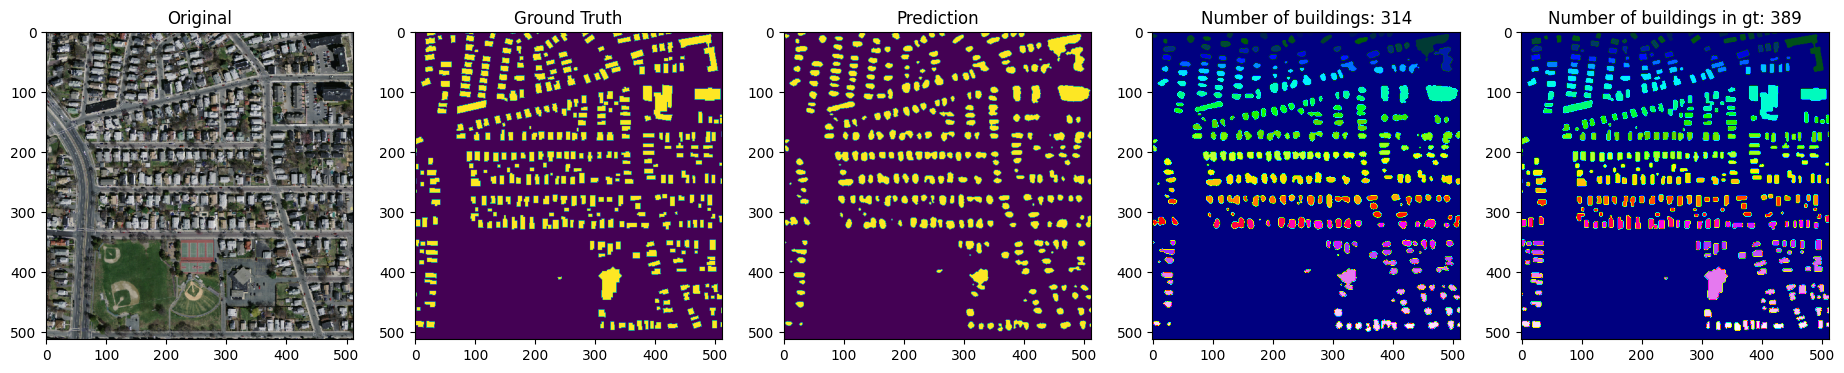

In [ ]:
number = 10 #56 ,34
pred = p[number,:,:]

opened_img, number_of_objects, blob_labels = post_processing(pred)
print("Number of Buildings in prediction: {}".format(number_of_objects[-1]))

gt = g[number,:,:]
opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)
print("Number of Buildings in Groundtruth: {}".format(number_of_objects1[-1]))

f, axs = plt.subplots(1,5, figsize=(23,23))
img = imgs[number,:,:,:]/255
img = np.reshape(img,(img.shape[0],img.shape[1],3))
# img = img.astype('uint8')
axs[0].imshow(img)
axs[0].set_title("Original")

gt = g[number,:,:]
gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
axs[1].imshow(gt)
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of buildings: {}".format(number_of_objects[-1]))

axs[4].imshow(blob_labels1, cmap='gist_ncar')
axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

f.show()

In [ ]:
for i in range(10):
    number = i
    img = p[number,:,:]

    opened_img, number_of_objects, blob_labels = post_processing(img)
    gt = g[number,:,:]
    opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)

    f, axs = plt.subplots(1,5, figsize=(23,23))
    img = imgs[number,:,:,:]/255
    img = np.reshape(img,(img.shape[0],img.shape[1],3))
    # img = img.astype('uint8')
    axs[0].imshow(img)
    axs[0].set_title("Original")

    gt = g[number,:,:]
    gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
    axs[1].imshow(gt)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(opened_img)
    axs[2].set_title("Prediction")

    axs[3].imshow(blob_labels, cmap='gist_ncar')
    axs[3].set_title("Number of buildings in prediction: {}".format(number_of_objects[-1]))

    axs[4].imshow(blob_labels1, cmap='gist_ncar')
    axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

    f.show()